# Tabular Playground Series


**진행중인 작업**

- 앞으로 해야할 일: 모델 미세조정과 피쳐 엔지니어링

이 노트북에서 나는 tree 방법들(랜덤포레스트,catboost,xgboost)에 집중할 것이다. 그리고 나는 자체적으로 정의된 중요도가 임계점을 넘기지 못한 변수들을 제거하고, 어떻게 각각의 변수들이 결합하여 각각의 행들을 예측하는 모델을 만드는지를 랜덤포레스트를 통해 깊이 볼 것이다.

**개요**

캐글 대회들은 재밌고 보람차다. 하지만, 그들은 상대적으로 이제 막 데이터 사이언스를 공부하려는 사람들을 위협할 수 있다. 과거에 캐글대회들은 featured 대회들보다 처음 공부하려는 사람들을 위한 playground 대회들을 접하기 쉬웠다.

이 대회의 목적은 재밌지만 덜 도전적이고 table 데이터를 다루는 것이다. 또한, 타이타닉 대회와 주요 대회들 사시에서 무언가를 찾는 사람들에게 좋을 것이다.

이 대회에서 데이터 셋은 인위적이지만, 실제 데이터에 기반하여 CTGAN을 사용해서 만들어졌다. 원래 데이터 셋은 보험 청구의 양을 예측하는것을 다룬다. 비록 변수들이 이름을 알 수 없게 해놨지만, 실제 세상의 변수들과 관련되어 있다.

**데이터**

훈련 세트는 300,000 행을 가지고 있고 테스트세트는 200,000 행을 가진다.
cat0부터 cat18까지 19개의 범주형 변수들이있고, cont0부터 cont10까지 11개의 연속형 변수들로 총 30개의 변수들이 있다.

In [20]:
# python 3 환경은 많은 분석 라이브러리들과 함께 제공된다.
# 도움을 주는 packages들을 불러온다.

import numpy as np # 선형대수
import pandas as pd # 데이터가공, CSV file 입출력 (e.g. pd.read_csv)

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# font
# https://www.kaggle.com/hwangchanghyun/malgun 
import matplotlib as mpl
import matplotlib.font_manager as fm

path='/kaggle/input/malgun/malgun.ttf'
mpl.rcParams['axes.unicode_minus']=False
fontprop=fm.FontProperties(fname=path)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-mar-2021/train.csv
/kaggle/input/tabular-playground-series-mar-2021/test.csv
/kaggle/input/malgun/malgun.ttf


# 데이터 불러오기


In [2]:
train_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')
test_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/test.csv')
sub_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/sample_submission.csv')

test_df.head(3)

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10
0,5,A,F,A,A,F,BI,A,AH,AX,...,0.735690,0.578366,0.723154,0.228037,0.356227,0.551249,0.655693,0.598331,0.359987,0.947489
1,6,A,H,C,A,E,AB,I,F,N,...,0.313703,0.928885,0.516602,0.600169,0.795224,0.248987,0.654614,0.347944,0.565520,0.388580
2,8,A,N,C,A,F,AB,A,AH,BC,...,0.448201,0.424876,0.344729,0.242073,0.270632,0.746740,0.335590,0.341238,0.252289,0.411592


# 연속형과 범주형 변수들로 나누기

In [3]:
feature_cols = train_df.drop(['id', 'target'], axis=1).columns

## 데이터를 나누는 여러 방법들이 있다.
numerical_columns = train_df[feature_cols].select_dtypes(include=['int64','float64']).columns
categorical_columns = train_df[feature_cols].select_dtypes(exclude=['int64','float64']).columns

## 범주형 변수를 변환하는 동안에 같은 수를 얻기 위해서 train과 test를 합친다.
train_indexs = train_df.index
test_indexs = test_df.index

df =  pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)
df = df.drop(['id', 'target'], axis=1)
train_df

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,A,I,A,B,B,BI,A,S,Q,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,A,I,A,A,E,BI,K,W,AD,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,A,K,A,A,E,BI,A,E,BM,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,A,K,A,C,E,BI,A,Y,AD,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,A,I,G,B,E,BI,C,G,Q,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
299995,499993,A,N,F,A,E,BU,A,AS,K,...,0.662428,0.671927,0.390566,0.145840,0.262767,0.514248,0.519340,0.617436,0.688007,0
299996,499995,A,K,A,A,G,BI,A,K,AE,...,0.821657,0.620356,0.384891,0.735879,0.547731,0.726653,0.470575,0.275743,0.638939,0
299997,499996,A,G,M,A,H,BI,C,L,F,...,0.407037,0.232436,0.832482,0.810663,0.596939,0.308821,0.373997,0.518024,0.452144,1
299998,499997,B,H,A,D,B,BI,A,AA,AX,...,0.808045,0.630708,0.346898,0.735147,0.563488,0.609836,0.680430,0.318453,0.335822,0


# 탐색적 데이터 분석


우린 trainset과 testset에서 몇몇 변수들이 강한 상관관계를 가지는것을 볼 수 있다.

- cont2와 cont1은 0.9의 매우 강한 상관관계를 갖는다.
- 다른 것도 그러한 경우가 있다.

우리가 만들려고 하는 모델에 좋은편이다.

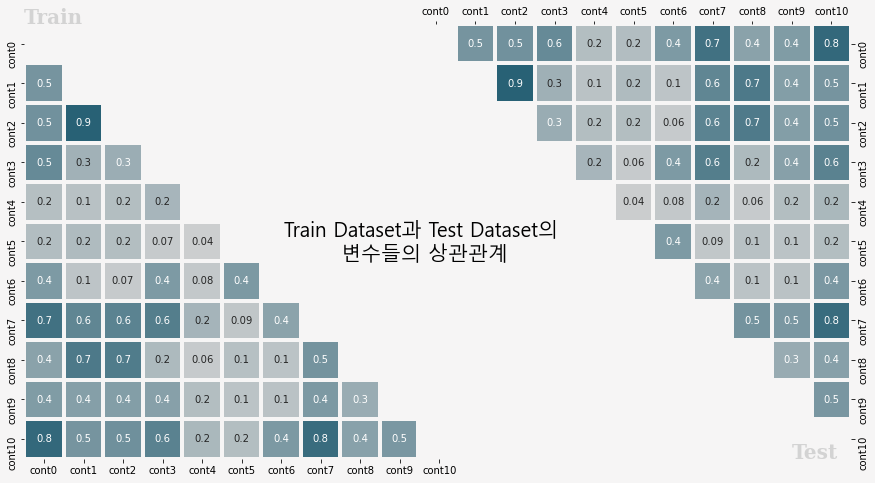

In [21]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(18, 8), facecolor=background_color)
gs = fig.add_gridspec(1, 2)
gs.update(wspace=-0.36, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
colors = ["#fbfbfb", "lightgray","#0e4f66"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

ax0.set_facecolor(background_color)
ax0.text(0, 0, 'Train', fontsize=20, fontweight='bold', fontfamily='serif',color='lightgray')

ax1.set_facecolor(background_color)
ax1.text(9.5, 11, 'Test', fontsize=20, fontweight='bold', fontfamily='serif',color='lightgray')


fig.text(0.5,0.5,'Train Dataset과 Test Dataset의\n 변수들의 상관관계', fontsize=20, fontweight='bold',va='center',ha='center',fontproperties=fontprop)

corr = train_df[numerical_columns].corr().abs()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, ax=ax0, vmin=-1, vmax=1, annot=True, square=True, mask=mask,
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g',linewidth=3,linecolor=background_color)


corr = test_df[numerical_columns].corr().abs()
mask = np.tril(corr)
sns.heatmap(corr, ax=ax1, vmin=-1, vmax=1, annot=True, square=True, mask=mask,
            cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap, fmt='.1g',linewidth=3,linecolor=background_color)
ax1.xaxis.tick_top()
ax1.yaxis.tick_right()

plt.show()

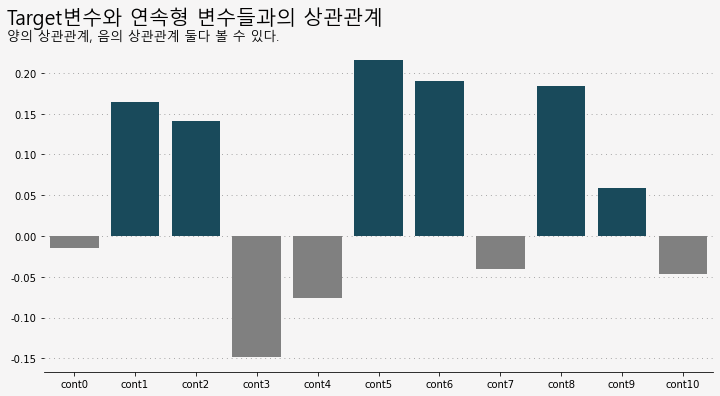

In [22]:
background_color = "#f6f5f5"

fig = plt.figure(figsize=(12, 6), facecolor=background_color)
gs = fig.add_gridspec(1, 1)
ax0 = fig.add_subplot(gs[0, 0])

ax0.set_facecolor(background_color)
ax0.text(-1.1, 0.26, 'Target변수와 연속형 변수들과의 상관관계', fontsize=20, fontweight='bold', fontproperties=fontprop)
ax0.text(-1.1, 0.24, '양의 상관관계, 음의 상관관계 둘다 볼 수 있다.' ,fontsize=13, fontweight='light', fontproperties=fontprop)

chart_df = pd.DataFrame(train_df[numerical_columns].corrwith(train_df['target']))
chart_df.columns = ['corr']
chart_df['positive'] = chart_df['corr'] > 0

sns.barplot(x=chart_df.index, y=chart_df['corr'], ax=ax0, palette=chart_df.positive.map({True: '#0e4f66', False: 'gray'}), zorder=3,dodge=False)
ax0.grid(which='major', axis='y', zorder=0, color='gray', linestyle=':', dashes=(1,5))
ax0.set_ylabel('')


for s in ["top","right", 'left']:
    ax0.spines[s].set_visible(False)

plt.show()

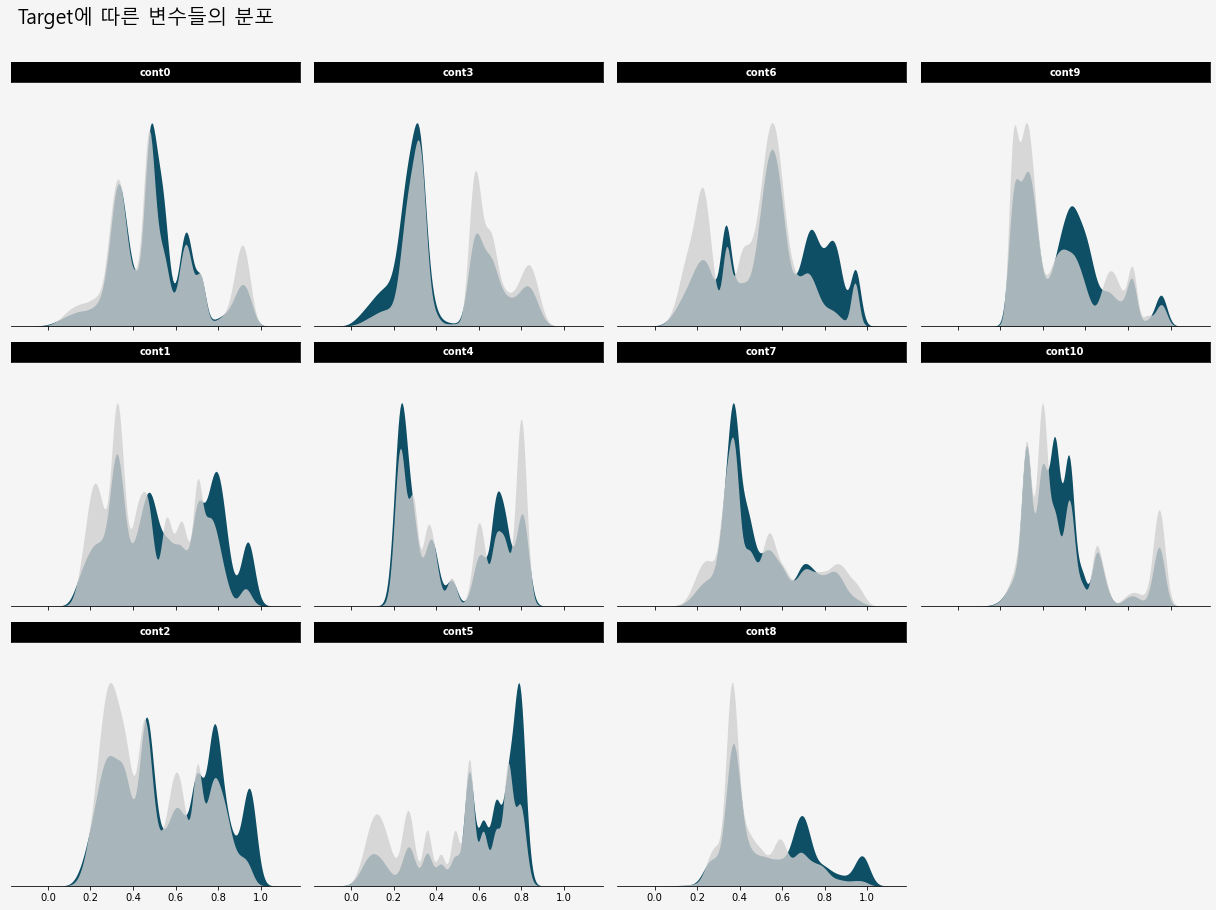

In [26]:
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(3, 4, figsize=(17, 12), sharex=True)
fig.set_facecolor('#f6f5f5') 

for i in range(11): 
    sns.kdeplot(data=train_df[train_df['target']==1], x=f'cont{i}', 
                fill=True,
                linewidth=0,
                color='#0e4f66', alpha=1,
                ax=ax[i%3][i//3])
    
    sns.kdeplot(data=train_df[train_df['target']==0], x=f'cont{i}', 
                fill=True,
                linewidth=0,
                color='#d0d0d0', alpha=0.8,
                ax=ax[i%3][i//3])
    
    ax[i%3][i//3].set_yticks([])
    ax[i%3][i//3].set_ylabel('',visible=False)
    ax[i%3][i//3].set_xlabel('',visible=False)
    ax[i%3][i//3].margins(0.05, 0.2)
    ax[i%3][i//3].set_facecolor(background_color) 
    for s in ["top","right", 'left']:
            ax[i%3][i//3].spines[s].set_visible(False)           
            
    # bar
    divider = make_axes_locatable(ax[i%3][i//3])
    cax = divider.append_axes("top", size="8%", pad=0)
    cax.get_xaxis().set_visible(False)
    cax.get_yaxis().set_visible(False)
    cax.set_facecolor('black')

    at = AnchoredText(f'cont{i}', loc=10, 
                      prop=dict(backgroundcolor='black',
                                size=10, color='white', weight='bold'))
    cax.add_artist(at)
    
ax[-1][-1].set_visible(False)
fig.text(0.018, 1.03, 'Target에 따른 변수들의 분포', fontsize=20, fontweight='bold', fontproperties=fontprop)

plt.tight_layout()
plt.show()

# 모델링

베이스라인 코드로 간단한 랜덤포레스트 분류기를 사용할 것이다. 그 후 그래디언트 부스팅을 사용할 것이다.

마지막으로, soft voting 분류기를 사용하여 각각의 모델의 점수가 오르는지 볼 것이다.

In [27]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from category_encoders import CatBoostEncoder, LeaveOneOutEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.svm import LinearSVC

# 데이터 준비

In [28]:
# 범주형 변수들을 encoding한다.

for c in train_df.columns:
    if train_df[c].dtype=='object': 
        lbl = LabelEncoder()
        lbl.fit(list(train_df[c].values) + list(test_df[c].values))
        train_df[c] = lbl.transform(train_df[c].values)
        test_df[c] = lbl.transform(test_df[c].values)
        
display(train_df.head())

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,target
0,0,0,8,0,1,1,33,0,44,54,...,0.759439,0.795549,0.681917,0.621672,0.592184,0.791921,0.815254,0.965006,0.665915,0
1,1,0,8,0,0,4,33,8,48,3,...,0.386385,0.541366,0.388982,0.357778,0.600044,0.408701,0.399353,0.927406,0.493729,0
2,2,0,10,0,0,4,33,0,30,38,...,0.343255,0.616352,0.793687,0.552877,0.352113,0.388835,0.412303,0.292696,0.549452,0
3,3,0,10,0,2,4,33,0,50,3,...,0.831147,0.807807,0.800032,0.619147,0.221789,0.897617,0.633669,0.760318,0.934242,0
4,4,0,8,6,1,4,33,2,32,54,...,0.338818,0.277308,0.610578,0.128291,0.578764,0.279167,0.351103,0.357084,0.328960,1


In [29]:
target = train_df.pop('target')
X_train, X_test, y_train, y_test = train_test_split(train_df, target, train_size=0.80)

# 랜덤포레스트 점수

시작이 좋다. 

이 모델의 장점은 훈련이 빠르다. 이는 업계에서 중요하다.

In [30]:
# Simple Random Forest

rfc = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1)
rfc.fit(X_train, y_train)
# 긍정적으로 분류한 클래스를 예측한것을 가져온다.
rfc_pred = rfc.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, rfc_pred)
print(f'{score:0.5f}')

0.87986


In [31]:
rf_df = pd.DataFrame(data=[roc_auc_score(y_test, rfc_pred)], 
             columns=['Random Forest Score'],
             index=["ROC AUC Score"])

# 랜덤포레스트 모델 해석을 자세히 해보기

처음 변수 중요도를 waterfall chart를 통해 보고 각 변수들이 각 record(행)에 얼만큼 영향을 주는지 보자.

In [32]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'Feature':df.columns, 'Importance':m.feature_importances_}
                       ).sort_values('Importance', ascending=False)

In [33]:
fi = rf_feat_importance(rfc, X_train)
fi[:10]

,Feature,Importance
17,cat16,0.250126
16,cat15,0.175572
19,cat18,0.108633
15,cat14,0.052026
12,cat11,0.048702
25,cont5,0.047102
3,cat2,0.038994
1,cat0,0.038512
18,cat17,0.033336
26,cont6,0.029450


# 업계에서 간단한 모델이 종종 좋은 편이다.

이것은 모델을 빠르게 만들수있고, 결과 해석을 쉽게 할 수 있다.

랜덤포레스트의 변수 중요도가 0.005보다 큰 변수들만 골라서 다시 돌려본다. 

In [34]:
to_keep = fi[fi.Importance>0.005].Feature
len(to_keep)

23

In [35]:
X_train_imp  =  X_train[to_keep]
X_test_imp  = X_test[to_keep]

In [36]:
# re-model
rfc = RandomForestClassifier(n_estimators=300, max_depth=10, n_jobs=-1)
rfc.fit(X_train_imp, y_train)
rfc_pred = rfc.predict_proba(X_test_imp)[:, 1] 
score = roc_auc_score(y_test, rfc_pred)
print(f'{score:0.5f}') 

0.87938


괜찮은 점수이지만, 별로 연구할것은 없어보인다.

In [37]:
len(X_train.columns), len(X_train_imp.columns)

(31, 23)

In [40]:
!pip install treeinterpreter
!pip install waterfallcharts

In [41]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

예측은 랜덤포레스트가 만드는 예측이다. bias는 종속변수의 평균을 기반으로 하는 예측이다. 
기여도는 각각의 독립변수가 만드는 예측변화의 총 변화를 말한다. 그러므로 기여도의 합 + bias는 각 행의 예측에 대하여 같아야한다. 

In [42]:
row =  X_test_imp.values[None,100] 
prediction, bias, contributions = treeinterpreter.predict(rfc, row)
prediction[0], bias[0]

(array([0.96684562, 0.03315438]), array([0.73500114, 0.26499886]))

In [43]:
contributions = [contributions[0][i][0] for i in range(len(contributions[0]))]

In [44]:
colnames = X_test_imp.columns[0:].values

# Waterfall Chart

왜 유용한가?

비즈니스에 주어진 예측이 왜 특정 행또는 입력에 대한 예측을 하는지 알고싶어한다. 단순히 변수 중요도를 주기보다 실제로 어떻게 상호작용을 하여 결과가 나오는지 보여줄 수 있다.

아래 사이트에서 참고 할 수 있다. 

https://github.com/chrispaulca/waterfall

매우 유익하고 회귀문제도 풀수있다.

다만, 제대로 customize하는 방법을 찾진 못했다.

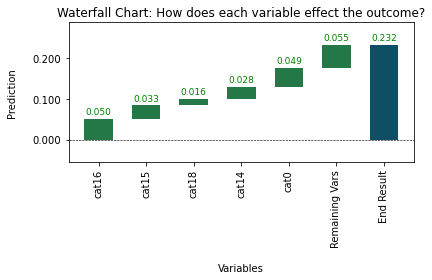

In [45]:
import waterfall_chart
my_plot=waterfall_chart.plot(colnames,contributions, rotation_value=90, threshold=0.3,formatting='{:,.3f}',net_label="End Result", other_label="Remaining Vars",
            Title="Waterfall Chart: How does each variable effect the outcome?", x_lab = "Variables", y_lab = "Prediction",green_color='#247747',blue_color='#0e4f66',red_color='#ff0000')

# CatBoost 점수

In [46]:
params = {'iterations': 5000,
         'learning_rate':0.013933182980403087,
          'reg_lambda': 47.79748127808107,
         'depth':5,
         'eval_metric':'AUC',
         'verbose':200,
         'od_type':'Iter',
         'od_wait':50}

In [47]:
cat_model = CatBoostClassifier(**params)
cat_model.fit(X_train,y_train)
cb_pred = cat_model.predict_proba(X_test)[:, 1] 
score = roc_auc_score(y_test, cb_pred)
print(f'{score:0.5f}') 

0:	total: 122ms	remaining: 10m 8s
200:	total: 12.3s	remaining: 4m 53s
400:	total: 23.8s	remaining: 4m 33s
600:	total: 35s	remaining: 4m 16s
800:	total: 46.8s	remaining: 4m 5s
1000:	total: 58.3s	remaining: 3m 52s
1200:	total: 1m 9s	remaining: 3m 40s
1400:	total: 1m 21s	remaining: 3m 29s
1600:	total: 1m 33s	remaining: 3m 17s
1800:	total: 1m 44s	remaining: 3m 5s
2000:	total: 1m 56s	remaining: 2m 54s
2200:	total: 2m 7s	remaining: 2m 42s
2400:	total: 2m 19s	remaining: 2m 30s
2600:	total: 2m 30s	remaining: 2m 19s
2800:	total: 2m 42s	remaining: 2m 7s
3000:	total: 2m 53s	remaining: 1m 55s
3200:	total: 3m 5s	remaining: 1m 44s
3400:	total: 3m 16s	remaining: 1m 32s
3600:	total: 3m 28s	remaining: 1m 20s
3800:	total: 3m 39s	remaining: 1m 9s
4000:	total: 3m 51s	remaining: 57.7s
4200:	total: 4m 2s	remaining: 46.2s
4400:	total: 4m 14s	remaining: 34.6s
4600:	total: 4m 25s	remaining: 23s
4800:	total: 4m 37s	remaining: 11.5s
4999:	total: 4m 48s	remaining: 0us
0.89187


In [49]:
cb_df = pd.DataFrame(data=[roc_auc_score(y_test, cb_pred)], 
             columns=['CatBoost Score'],
             index=["ROC AUC Score"])

# XGBoost 점수

In [50]:
xgb = XGBClassifier(eval_metric="auc",
                          random_state=42,
                          tree_method="gpu_hist",
                          gpu_id="0",
                          use_label_encoder=False,verbose=200)


xgb_model = CatBoostClassifier(**params)
xgb_model.fit(X_train,y_train)
xgb_pred = xgb_model.predict_proba(X_test)[:, 1]
score = roc_auc_score(y_test, xgb_pred)
print(f'{score:0.5f}') 

0:	total: 62.8ms	remaining: 5m 13s
200:	total: 12.1s	remaining: 4m 47s
400:	total: 23.6s	remaining: 4m 30s
600:	total: 35.3s	remaining: 4m 18s
800:	total: 46.6s	remaining: 4m 4s
1000:	total: 58.5s	remaining: 3m 53s
1200:	total: 1m 9s	remaining: 3m 41s
1400:	total: 1m 21s	remaining: 3m 28s
1600:	total: 1m 33s	remaining: 3m 17s
1800:	total: 1m 44s	remaining: 3m 5s
2000:	total: 1m 55s	remaining: 2m 53s
2200:	total: 2m 7s	remaining: 2m 42s
2400:	total: 2m 19s	remaining: 2m 31s
2600:	total: 2m 30s	remaining: 2m 19s
2800:	total: 2m 42s	remaining: 2m 7s
3000:	total: 2m 53s	remaining: 1m 55s
3200:	total: 3m 5s	remaining: 1m 44s
3400:	total: 3m 17s	remaining: 1m 32s
3600:	total: 3m 28s	remaining: 1m 20s
3800:	total: 3m 40s	remaining: 1m 9s
4000:	total: 3m 51s	remaining: 57.8s
4200:	total: 4m 2s	remaining: 46.2s
4400:	total: 4m 14s	remaining: 34.7s
4600:	total: 4m 26s	remaining: 23.1s
4800:	total: 4m 37s	remaining: 11.5s
4999:	total: 4m 49s	remaining: 0us
0.89187


In [53]:
xgb_df = pd.DataFrame(data=[roc_auc_score(y_test, xgb_pred)], 
             columns=['XGBoost Score'],
             index=["ROC AUC Score"])

In [54]:
fi = rf_feat_importance(xgb_model, X_train)
xgb10_fi = fi[:10]

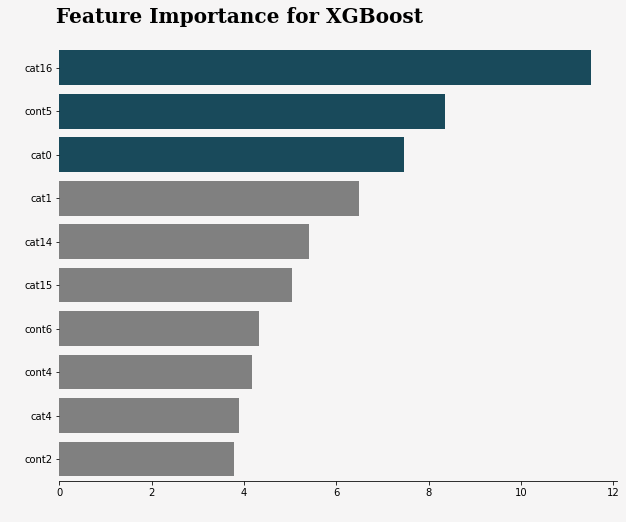

In [55]:
background_color = "#f6f5f5"

fig, ax = plt.subplots(1,1, figsize=(10, 8),facecolor=background_color)

color_map = ['gray' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] =  '#0e4f66'

sns.barplot(data=xgb10_fi,x='Importance',y='Feature',ax=ax,palette=color_map)
ax.set_facecolor(background_color) 
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
fig.text(0.12,0.92,"Feature Importance for XGBoost", fontsize=20, fontweight='bold', fontfamily='serif')

    
plt.xlabel(" ", fontsize=12, fontweight='light', fontfamily='serif',loc='left',y=-1.5)
plt.ylabel(" ", fontsize=12, fontweight='light', fontfamily='serif')

plt.show()

# Voting Classifier


Voting classifier는 모델들을 가져와 결과의 평균을 반환한다. 

hard voting classifier는 각 분류기가 한사람의 능력을 내고, 다수결로 뽑는다. 일반적으로 홀수개의 모델을 사용하므로 동률이 될 수 없다.

soft classifier는 선택한 모델들의 예측값들의 신뢰도의 평균을 반환한다. 만약, 평균 신뢰도가 50%를 넘는다면 1로 카운트한다. 

위의 3모델을 묶는다.

In [56]:
voting_clf = VotingClassifier(estimators = [('rfc',rfc),('cat_model',cat_model),('xgb_model',xgb_model)], voting = 'soft') 

In [57]:
voting_clf.fit(X_train,y_train)
vc_pred = voting_clf.predict_proba(X_test)[:, 1] 
score = roc_auc_score(y_test, vc_pred)
print(f'{score:0.5f}')

0:	total: 64.1ms	remaining: 5m 20s
200:	total: 11.6s	remaining: 4m 37s
400:	total: 23s	remaining: 4m 23s
600:	total: 34.7s	remaining: 4m 14s
800:	total: 46.1s	remaining: 4m 1s
1000:	total: 57.6s	remaining: 3m 49s
1200:	total: 1m 9s	remaining: 3m 40s
1400:	total: 1m 20s	remaining: 3m 27s
1600:	total: 1m 32s	remaining: 3m 16s
1800:	total: 1m 43s	remaining: 3m 4s
2000:	total: 1m 55s	remaining: 2m 52s
2200:	total: 2m 7s	remaining: 2m 41s
2400:	total: 2m 18s	remaining: 2m 30s
2600:	total: 2m 29s	remaining: 2m 18s
2800:	total: 2m 41s	remaining: 2m 6s
3000:	total: 2m 53s	remaining: 1m 55s
3200:	total: 3m 4s	remaining: 1m 43s
3400:	total: 3m 16s	remaining: 1m 32s
3600:	total: 3m 28s	remaining: 1m 20s
3800:	total: 3m 39s	remaining: 1m 9s
4000:	total: 3m 51s	remaining: 57.8s
4200:	total: 4m 2s	remaining: 46.2s
4400:	total: 4m 14s	remaining: 34.6s
4600:	total: 4m 26s	remaining: 23.1s
4800:	total: 4m 37s	remaining: 11.5s
4999:	total: 4m 49s	remaining: 0us
0:	total: 63.8ms	remaining: 5m 18s
200:	to

In [59]:
vc_df = pd.DataFrame(data=[roc_auc_score(y_test, vc_pred)], 
             columns=['Voting Classifier Score'],
             index=["ROC AUC Score"])

# 결과

최적의 파라미터를 위해 조정하지 않았다. 왜냐하면 너무 오래걸리기 때문이다. 

간단한 gridssearch는 조금의 점수 향상 시킬수있다.

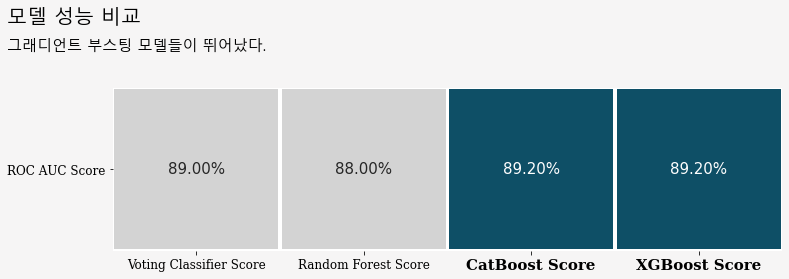

In [61]:
# Overall
colors = ["lightgray","#0e4f66"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
background_color = "#f6f5f5"


fig = plt.figure(figsize=(12,3), facecolor=background_color) # create figure
gs = fig.add_gridspec(1, 1)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])


df_models = round(pd.concat([vc_df,rf_df,cb_df,xgb_df], axis=1),3)
sns.heatmap(df_models, cmap=colormap,annot=True,fmt=".2%",vmax=0.891,vmin=0.89, linewidths=2.5,cbar=False,annot_kws={"fontsize":15})


ax0.text(-0.63,-0.4,'모델 성능 비교',fontproperties=fontprop,fontsize=20,fontweight='bold')
ax0.text(-0.63,-0.23,'그래디언트 부스팅 모델들이 뛰어났다.',fontproperties=fontprop,fontsize=15)


ax0.set_yticklabels(ax0.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=12)
ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=0, fontsize=12)

for lab, annot in zip(ax0.get_xticklabels(), ax0.texts):
    text =  lab.get_text()
    if text == 'CatBoost Score': 
        lab.set_weight('bold')
        lab.set_size(15)
        lab.set_color('black')
        
for lab, annot in zip(ax0.get_xticklabels(), ax0.texts):
    text =  lab.get_text()
    if text == 'XGBoost Score': 
        lab.set_weight('bold')
        lab.set_size(15)
        lab.set_color('black')

plt.show()

# label encoding말고, one-hot encoding을 해본다.

어떻게 범주형 변수들을 인코딩하는지가 ROC AUC 점수의 변화를 만드는지 확인하기 위함이다.

In [ ]:
#train_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/train.csv')
#test_df = pd.read_csv('/kaggle/input/tabular-playground-series-mar-2021/test.csv')


#feature_cols = train_df.drop(['id', 'target'], axis=1).columns

#numerical_columns = train_df[feature_cols].select_dtypes(include=['int64','float64']).columns
#categorical_columns = train_df[feature_cols].select_dtypes(exclude=['int64','float64']).columns

#train_indexs = train_df.index
#test_indexs = test_df.index

#df =  pd.concat(objs=[train_df, test_df], axis=0).reset_index(drop=True)
#df = df.drop(['id', 'target'], axis=1)

#train_df = pd.read_csv('../input/tabular-playground-series-mar-2021/train.csv')
#test_df = pd.read_csv('../input/tabular-playground-series-mar-2021/test.csv')
#combine_df = pd.concat([train_df, test_df], axis=0)

#for col in categorical_columns:
#    combine_df[col] = pd.get_dummies(combine_df[col],drop_first=True)
#train_df = combine_df.iloc[:len(train_df), :]
#test_df = combine_df.iloc[len(train_df):, :]
#test_df = test_df.drop('target', axis=1)

In [ ]:
#target = train_df.pop('target')
#X_train, X_test, y_train, y_test = train_test_split(train_df, target, train_size=0.80)

In [ ]:
# Simple Random Forest

#rfc = RandomForestClassifier(n_estimators=200, max_depth=7, n_jobs=-1)
#rfc.fit(X_train, y_train)
#rfc_pred = rfc.predict_proba(X_test)[:, 1] 
#score = roc_auc_score(y_test, rfc_pred)
#print(f'{score:0.5f}') 

In [ ]:
#xgb = XGBClassifier(eval_metric="auc",
 #                         random_state=42,
  #                        tree_method="gpu_hist",
   #                       gpu_id="0",
    #                      use_label_encoder=False,verbose=200)


#xgb_model = CatBoostClassifier(**params)
#xgb_model.fit(X_train,y_train)
#xgb_pred = xgb_model.predict_proba(X_test)[:, 1]
#score = roc_auc_score(y_test, xgb_pred)
#print(f'{score:0.5f}') 

In [ ]:
#cat_model = CatBoostClassifier(**params)
#cat_model.fit(X_train,y_train)
#cb_pred = cat_model.predict_proba(X_test)[:, 1] 
#score = roc_auc_score(y_test, cb_pred)
#print(f'{score:0.5f}') 

# 모든 모델들은 one-hot encoding으로 했을 때 별로 안좋았다.

# 결론

하이퍼 파라미터 튜닝을 하겠다는 의지없이 위 결과를 얻어서 좋다.

다음 피쳐 엔지니어링을 한다면 조금의 성능향상을 믿는다.

랜덤포레스트 모델을 분석하는 방법들을 통해 봤다. 분명 유용할 것이다. 